In [1]:
!pip install tqdm
!pip install seaborn
!pip install fpdf2

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from fpdf import FPDF

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [3]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/brdd/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    
import functions_metrics as fm
import functions_read_data as rdat
import functions_model_definition as md
import functions_gradcam as gc
import functions_plot_heatmap as phm

/tf


## Load Data

In [4]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
DATA_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/data/"

version = "10Fold_sigmoid_V0" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
generate_heatmap_and_save = False
generate_pictures = True

hm_of_pred = True # if true heatmap of prediction will be generated else heatmap of class 1
last_layer_only = True # if true only last layer will be used for gradcam else once last and once all layers

# Define Model Version
model_version = 1

if version.startswith("10Fold"):
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/" + version + "/"
    DATA_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/data/" + version + "/"
    PIC_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/pictures/" + version + "/"
    pic_save_name = version + "_M" + str(model_version) + "_predclgc"
    
elif version == "andrea":
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/andrea_split/"
    DATA_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/data/andrea_split/"
    PIC_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/pictures/andrea_split/"
    pic_save_name = "andrea_split" + "_predclgc"

/tf/notebooks/brdd/xAI_stroke_3d


In [5]:
## load images and ids

if version == "andrea": ## for andrea
    with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
        # with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
        # both images are the same
            X_in = h5["X"][:]
            pat = h5["pat"][:]
            
    # load results
    path_results = DATA_DIR + "all_tab_results_andrea_split.csv" # andrea split
    
elif version.startswith("10Fold"): ## for 10 Fold       
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
        num_models = 5
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
        num_models = 10
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
        num_models = 5
    elif version.endswith("V3"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3.csv", sep=",")
        num_models = 5
    pat = id_tab["p_id"].to_numpy()
    X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
    
    # load results
    path_results = DATA_DIR + "all_tab_results_" + version + "_M" + str(model_version) + ".csv" # 10 Fold

all_results = pd.read_csv(path_results, sep=",")
all_results = all_results.sort_values("p_idx")

In [6]:
## load patient data
PAT_CSV_DIR = "/tf/notebooks/hezo/stroke_zurich/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")
pat_dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia,iaty,ivty
0,101,1,"85,6",0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN
1,102,1,"66,7",1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN
2,103,0,"29,2",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,104,0,83,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,NaN,NaN
4,105,6,"89,2",0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,540,2,80,0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0
514,541,0,19,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1
515,542,1,68,1,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0
516,543,4,74,0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0


## Model

In [7]:
# define model
input_dim = (128, 128, 28, 1)

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    pred_idx = 0
    LOSS = "binary_crossentropy"
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    pred_idx = 1
    LOSS = tf.keras.losses.categorical_crossentropy
    
if version.endswith("f"):
    layer_connection = "flatten"
else:
    layer_connection = "globalAveragePooling"

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [8]:
# Define Model Name
def generate_model_name(which_split, model_nr, model_version = model_version, path = WEIGHT_DIR):
    if layer_connection == "globalAveragePooling":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_avg_layer_paper_model_" + last_activation + "_activation_"  + str(model_version) + str(model_nr) + ".h5")
    elif layer_connection == "flatten":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_flat_layer_paper_model_" + last_activation + "_activation_" + str(model_version) + str(model_nr) + ".h5")

# Plot GradCams

## Calculate Heatmap and Heatmap Uncertainty

In [9]:
# select all patients
p_ids = all_results["p_id"].to_numpy()

if version == "andrea":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results[all_results.test_split == 6], pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # andrea split
elif version.startswith("10Fold"):
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in,
        gen_model_name = generate_model_name,
        num_models = num_models) # 10 Fold

In [10]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

In [11]:
vis_layers

['conv3d', 'conv3d_1', 'conv3d_2', 'conv3d_3']

In [12]:
res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_12,y_pred_model_13,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,205,1,1,1.0,0,val,train,train,train,train,...,0.006181,0.013081,0.010683,0.014991,0.012591,0.225491,0,0.011203,0.023237,True
1,206,2,2,1.0,0,val,train,train,train,train,...,0.024134,0.049767,0.028247,0.041919,0.037599,0.225491,0,0.023930,0.066490,True
2,367,3,3,0.0,0,train,train,train,train,val,...,0.131908,0.243230,0.315786,0.214386,0.204826,0.225491,0,0.080713,0.259467,True
3,41,4,5,0.0,0,train,test,train,train,train,...,0.716669,0.567527,0.606706,0.632576,0.635252,0.225491,1,0.073403,0.234623,False
4,246,5,6,3.0,1,train,val,train,train,train,...,0.245842,0.348741,0.214166,0.255132,0.251216,0.225491,1,0.062966,0.199155,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,81,403,555,0.0,0,train,test,train,train,train,...,0.149244,0.191791,0.250303,0.174730,0.170676,0.225491,0,0.048965,0.151572,True
403,122,404,556,0.0,0,train,train,test,train,train,...,0.005016,0.002759,0.005417,0.005433,0.004173,0.225491,0,0.004365,0.000000,True
404,406,405,557,1.0,0,train,train,train,train,val,...,0.017060,0.018309,0.032593,0.021798,0.021210,0.225491,0,0.006236,0.006357,True
405,366,406,559,1.0,0,train,train,train,val,train,...,0.382259,0.497347,0.451662,0.383475,0.379759,0.225491,1,0.094122,0.305038,False


In [13]:
# lc = last conv layer
# ac = average over all conv layer

pred_hm_only = True
if pred_hm_only:
    gcpp_hm = "last"
    cmap = "jet"
    hm_positive=True
else:
    invert_hm = "none"
    gcpp_hm = "none"
    cmap = "bwr"
    hm_positive=False

if generate_heatmap_and_save:

    heatmaps_lc = []
    max_hm_slices_lc = []
    hm_mean_stds_lc = []

    heatmaps_ac = []
    max_hm_slices_ac = []
    hm_mean_stds_ac = []

    resized_imgs = []

    model_mode = "mean"
    for i in tqdm(range(len(res_table))):
        
        if pred_hm_only:
            invert_hm = "all" if res_table.y_pred_class[i] == 0 else "none"
        # else already defined above

        heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
        img = res_images[i:i+1], 
        cnn = model_3d,
        model_names = res_model_names[i],
        layers = vis_layers[-1],
        model_mode = model_mode,
        pred_index = pred_idx,
        invert_hm = invert_hm,
        gcpp_hm = gcpp_hm)

        heatmaps_lc.append(heatmap)
        max_hm_slices_lc.append(max_hm_slice)
        hm_mean_stds_lc.append(hm_mean_std)

        if not last_layer_only:
            heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[i:i+1], 
            cnn = model_3d,
            model_names = res_model_names[i],
            layers = vis_layers,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm,
            gcpp_hm = gcpp_hm)

            heatmaps_ac.append(heatmap)
            max_hm_slices_ac.append(max_hm_slice)
            hm_mean_stds_ac.append(hm_mean_std)

        resized_imgs.append(resized_img)
        
else:
    res_table = pd.read_csv(DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + ".csv",  sep = ",")
    heatmaps_lc = np.load(DATA_OUTPUT_DIR + "all_heatmaps_last_conv_layer_" + pic_save_name + ".npy")
    max_hm_slices_lc = np.load(DATA_OUTPUT_DIR + "all_max_activation_indices_last_conv_layer_" + pic_save_name + ".npy")
    if not last_layer_only:
        heatmaps_ac = np.load(DATA_OUTPUT_DIR + "all_heatmaps_average_conv_layer_" + pic_save_name + ".npy")
        max_hm_slices_ac = np.load(DATA_OUTPUT_DIR + "all_max_activation_indices_laverage_conv_layer_" + pic_save_name + ".npy")
    

In [14]:
if generate_heatmap_and_save:    
    res_table["heatmap_std_last_layer"] = hm_mean_stds_lc
    res_table["heatmap_unc_last_layer"] = (res_table["heatmap_std_last_layer"] - res_table.heatmap_std_last_layer.min()) / (
        res_table.heatmap_std_last_layer.max() - res_table.heatmap_std_last_layer.min())
    
    if not last_layer_only:
        res_table["heatmap_std_avg_layer"] = hm_mean_stds_ac
        res_table["heatmap_unc_avg_layer"] = (res_table["heatmap_std_avg_layer"] - res_table.heatmap_std_avg_layer.min()) / (
            res_table.heatmap_std_avg_layer.max() - res_table.heatmap_std_avg_layer.min())

#### Evaluate Metrics

In [15]:
max_hm_slices_lc

array([[[91, 83, 13],
        [76, 83, 14],
        [99, 76, 13],
        [83, 84, 13],
        [84, 84, 14]],

       [[59, 59, 13],
        [67, 43, 14],
        [59, 44, 14],
        [76, 84, 13],
        [59, 60, 14]],

       [[68, 84, 14],
        [76, 91, 13],
        [67, 83, 13],
        [83, 92, 14],
        [68, 84, 14]],

       ...,

       [[76, 91, 14],
        [83, 91, 13],
        [76, 84, 14],
        [68, 43, 14],
        [68, 43, 14]],

       [[28, 51, 23],
        [75, 52,  4],
        [28, 83, 23],
        [76, 83,  4],
        [28, 51, 23]],

       [[36, 60, 23],
        [68, 84, 14],
        [68, 84, 14],
        [75, 91, 13],
        [67, 43, 13]]])

In [16]:
if not last_layer_only:
    max_hm_slices_ac

In [17]:
if not last_layer_only:
    print(np.corrcoef(res_table["heatmap_unc_avg_layer"], res_table["heatmap_unc_last_layer"]))
    print(np.corrcoef(res_table["y_pred_unc"], res_table["heatmap_unc_avg_layer"]))
print(np.corrcoef(res_table["y_pred_unc"], res_table["heatmap_unc_last_layer"]))

[[1.         0.44178429]
 [0.44178429 1.        ]]


[Text(0.5, 0, 'true class'), Text(0, 0.5, 'heatmap uncertainty last layer')]

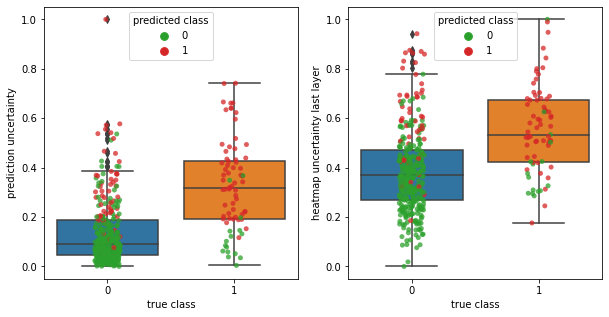

In [18]:
if not last_layer_only:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
else:
    fig, (ax1, ax3) = plt.subplots(1,2, figsize = (10, 5))

sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = res_table,
    ax = ax1)
sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = res_table,
    ax = ax1)
ax1.legend(title='predicted class', loc='upper center')
ax1.set(xlabel='true class', ylabel='prediction uncertainty')

if not last_layer_only:
    sns.boxplot(x = "unfavorable",
        y = "heatmap_unc_avg_layer",
        data = res_table,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "heatmap_unc_avg_layer",
        hue = 'y_pred_class',
        alpha = 0.75,
        palette=["C2", "C3"],
        data = res_table,
        ax = ax2)
    ax2.legend(title='predicted class', loc='upper center')
    ax2.set(xlabel='true class', ylabel='heatmap uncertainty avg layer')

sns.boxplot(x = "unfavorable",
    y = "heatmap_unc_last_layer",
    data = res_table,
    ax = ax3)
sns.stripplot(x = "unfavorable",
    y = "heatmap_unc_last_layer",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = res_table,
    ax = ax3)
ax3.legend(title='predicted class', loc='upper center')
ax3.set(xlabel='true class', ylabel='heatmap uncertainty last layer')

<AxesSubplot:xlabel='heatmap_unc_last_layer', ylabel='y_pred_unc'>

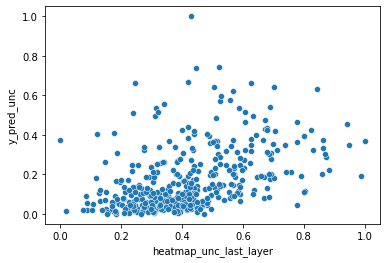

In [19]:
sns.scatterplot(
           x = "heatmap_unc_last_layer",
           y = "y_pred_unc",
            data = res_table)

#### Save Heatmaps, Images and updated Table

In [20]:
if generate_heatmap_and_save:
    res_table.to_csv(DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + ".csv",  index=False)
    np.save(DATA_OUTPUT_DIR + "all_heatmaps_last_conv_layer_" + pic_save_name + ".npy", heatmaps_lc)
    np.save(DATA_OUTPUT_DIR + "all_max_activation_indices_last_conv_layer_" + pic_save_name + ".npy", max_hm_slices_lc)
    if not last_layer_only:
        np.save(DATA_OUTPUT_DIR + "all_heatmaps_average_conv_layer_" + pic_save_name + ".npy", heatmaps_ac)
        np.save(DATA_OUTPUT_DIR + "all_max_activation_indices_laverage_conv_layer_" + pic_save_name + ".npy", max_hm_slices_ac)

## Plot Average Heatmaps

In [21]:
idx = np.where(res_table["y_pred_class"] == 0)

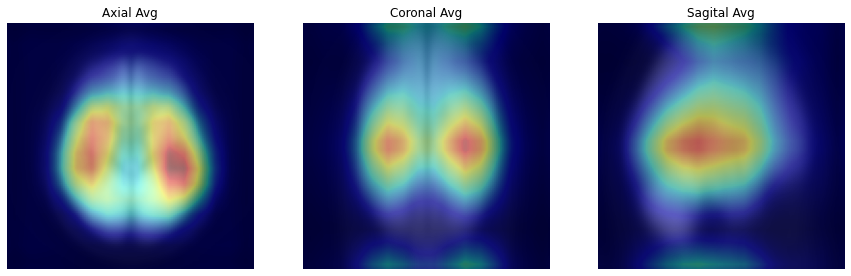

In [22]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
if not last_layer_only:
    mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

phm.plot_gradcam(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg")
if not last_layer_only:
    phm.plot_gradcam(mean_image, mean_hm_ac,
                version = "overlay",
                mode = "avg")

In [23]:
idx = np.where(res_table["y_pred_class"] == 1)

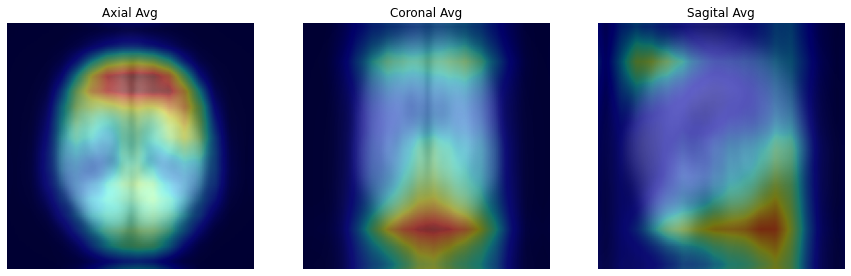

In [24]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
if not last_layer_only:
    mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

phm.plot_gradcam(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg")
if not last_layer_only:
    phm.plot_gradcam(mean_image, mean_hm_ac,
                version = "overlay",
                mode = "avg")

In [25]:
idx = np.arange(0,407)

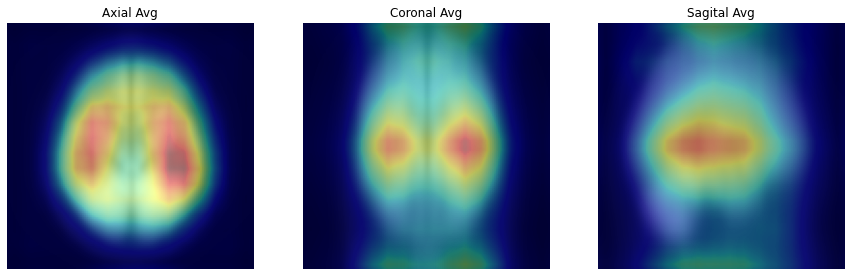

In [26]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
if not last_layer_only:
    mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

phm.plot_gradcam(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg")
if not last_layer_only:
    phm.plot_gradcam(mean_image, mean_hm_ac,
                version = "overlay",
                mode = "avg")

## Save Plots as PNG

In [27]:
if not last_layer_only:
    if generate_pictures:
        phm.plot_gradcams_last_avg_org(
            res_table = res_table, 
            vis_layers = vis_layers,
            res_images = res_images,
            res_model_names = res_model_names,
            model_3d = model_3d,
            layer_mode = "mean", 
            heatmap_mode = "avg", 
            save_path = PIC_OUTPUT_DIR, 
            save_name = pic_save_name, save = True)
        
    if generate_pictures:
        phm.plot_gradcams_last_avg_org(
            res_table = res_table, 
            vis_layers = vis_layers,
            res_images = res_images,
            res_model_names = res_model_names,
            model_3d = model_3d,
            layer_mode = "mean", 
            heatmap_mode = "max", 
            save_path = PIC_OUTPUT_DIR, 
            save_name = pic_save_name, save = True)
else:
    if generate_pictures:
        phm.plot_gradcams_avg_max_org(
            pat_data = pat_dat,
            res_table = res_table, 
            vis_layers = vis_layers[-1],
            res_images = res_images,
            res_model_names = res_model_names,
            model_3d = model_3d,
            layer_mode = "mean", 
            cmap = cmap,
            hm_positive = hm_positive,
            save_path = PIC_OUTPUT_DIR, 
            save_name = pic_save_name, save = True)
    


/tf/notebooks/brdd/xAI_stroke_3d/plot_function_gradcam.py:292: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (width,num_rows*width/3))


## Save Plots into PDF

In [37]:
## all ids
wrong_out = False
pat_ids = list(res_table["p_id"])

In [29]:
# ## only ids with low uncertainty and wrong classified
# wrong_out = True
# pat_ids = list(res_table.query("pred_correct == False and y_pred_unc < 0.2").p_id)
# res_table[res_table.p_id.isin(pat_ids)].to_csv(
#     DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + "_wrong_cl.csv",  index=False)

In [38]:
res_table[res_table.p_id.isin(pat_ids)]

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct,heatmap_std_last_layer,heatmap_unc_last_layer
0,205,1,1,1.0,0,val,train,train,train,train,...,0.010683,0.014991,0.012591,0.225491,0,0.011203,0.023237,True,0.047322,0.282184
1,206,2,2,1.0,0,val,train,train,train,train,...,0.028247,0.041919,0.037599,0.225491,0,0.023930,0.066490,True,0.053677,0.365442
2,367,3,3,0.0,0,train,train,train,train,val,...,0.315786,0.214386,0.204826,0.225491,0,0.080713,0.259467,True,0.051038,0.330860
3,41,4,5,0.0,0,train,test,train,train,train,...,0.606706,0.632576,0.635252,0.225491,1,0.073403,0.234623,False,0.069406,0.571527
4,246,5,6,3.0,1,train,val,train,train,train,...,0.214166,0.255132,0.251216,0.225491,1,0.062966,0.199155,True,0.063267,0.491099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,81,403,555,0.0,0,train,test,train,train,train,...,0.250303,0.174730,0.170676,0.225491,0,0.048965,0.151572,True,0.063742,0.497322
403,122,404,556,0.0,0,train,train,test,train,train,...,0.005417,0.005433,0.004173,0.225491,0,0.004365,0.000000,True,0.037530,0.153886
404,406,405,557,1.0,0,train,train,train,train,val,...,0.032593,0.021798,0.021210,0.225491,0,0.006236,0.006357,True,0.041672,0.208150
405,366,406,559,1.0,0,train,train,train,val,train,...,0.451662,0.383475,0.379759,0.225491,1,0.094122,0.305038,False,0.092191,0.870062


In [39]:
pdf = FPDF()
pdf.set_auto_page_break(0)

# imagelist is the list with all image filenames
for patient in tqdm(pat_ids):
    
    name_start = PIC_OUTPUT_DIR + "pat" + str(patient) + "_" + pic_save_name
    
    if not last_layer_only:
        pdf.add_page(orientation = "L", format = "A4")
        x,y,w,h = (0,10,160,160)
        pdf.image(name_start + "_last_and_all_layers_avg.png", x,y,w,h)
        x,y,w,h = (140,10,160,160)
        pdf.image(name_start + "_last_and_all_layers_max.png", x,y,w,h)
    else:
        pdf.add_page(orientation = "P", format = "A4")
        x,y,w,h = (0,10,205,205)
        pdf.image(name_start + "last_layer_avg_max_orig.png", x,y,w,h)
        
    
if wrong_out:
    pdf.output(PIC_OUTPUT_DIR + "10Fold_ensembling" + pic_save_name[6:] + "_all_patients_wrong_cl.pdf", "F")
else:
    pdf.output(PIC_OUTPUT_DIR + "10Fold_ensembling" + pic_save_name[6:] + "_all_patients.pdf", "F")


100%|██████████| 407/407 [01:08<00:00,  5.96it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
